In [2]:
#importing stuff
from io import StringIO
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sample_rate = 32 #Hz
sensor_min = -1.5 * 9.8 #g
sensor_max =  1.5 * 9.8 #g
sample_res = 63

def normalData(_data):
    data = sensor_min + (_data/sample_res) * (sensor_max - sensor_min)
    return data

In [3]:
#%ls HMP_Dataset/Walk/
def parseAdlTxt(file):
    #s = "HMP_Dataset/Walk/Accelerometer-2011-03-24-09-51-07-walk-f1.txt"
    data = np.genfromtxt(file, dtype=np.float32, delimiter=" ")
    #normalize data here
    return data

In [4]:
def getRecordsFromTxt(folderPath):
    for root, dirs, files in os.walk(folderPath, topdown=False):
#         print(root)
#         print(dirs)
        prev_shape = None
        records = [] #append a list
        for name in files:
            data = normalData(parseAdlTxt(os.path.join(root, name)))

#             if(prev_shape != None and prev_shape != data.shape):
#                 print("Error: data sample length not uniform ", data.shape)
#                 exit(-1)
#             else:
#                 prev_shape = data.shape

            records.append(data)
            #print(name, data.shape)
    return records

In [5]:
records = getRecordsFromTxt("HMP_Dataset/Walk/")
# print(records[0].shape[0])
#print(np.round(0.6))
#https://www.programcreek.com/python/example/100533/scipy.signal.medfilt
# r = sp.signal.medfilt(records[0], 7)
# print(r.shape)
def applyFil(records, med_size, resample_rate):
    resample_factor = resample_rate / sample_rate
    for i, r in enumerate(records):
        resample_length = np.ceil(resample_factor * r.shape[0])
        r = sp.signal.medfilt(r, med_size)
        r = sp.signal.resample(r, resample_length.astype(np.int32))
        records[i] = r

    return records

In [6]:
# records = getRecordsFromTxt("HMP_Dataset/Walk/")
# print(len(records))
#print(np.random.randint(0,3))
def randSegFromRecords(records, seg_length):
    rand_r_index = np.random.randint(0, len(records))
    r = records[rand_r_index]
    #print("r ", r.shape)
    if(seg_length > r.shape[0]):
        print("desired segment length exceeds sample length")
        exit()
    seg_start = np.random.randint(0, np.maximum(r.shape[0] - seg_length, 1))
    #print("seg_start ", seg_start)
    r_slice = r[seg_start:(seg_start + seg_length)]
    #print("seg_start + seg_length ", seg_start + seg_length)
    #print("r_slice ", r_slice.shape)
    
    return r_slice

In [7]:
def sampleMeanShift3DPlot(data):
    x = np.linspace(0,0,1)
    y = np.linspace(0,0,1)
    z = np.linspace(0, data.shape[0], data.shape[0])

    x,y,z = np.meshgrid(x,y,z)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    data = np.swapaxes(data, 0, 1)
    [bx, by, bz] = data
    bx = bx - np.mean(bx)
    by = by - np.mean(by)
    bz = bz - np.mean(bz)


    #normalize sample-z for plotting
    z_min = np.min(bz)
    z_max = np.max(bz)
    z_norm_factor = 1 / (z_max - z_min)

    bz = (bz * z_norm_factor) + z
    #bz = 0

    ax.quiver(x,y,z,bx,by,bz,color='b',length=0.5,normalize=True)
    plt.title('Walking accelerometer data')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

In [8]:
def sampleMeanShiftPlot(data, sample_rate):
    
    t = np.arange(0, data.shape[0] / sample_rate, 1 / sample_rate)

    data = np.swapaxes(data, 0, 1)
    [bx, by, bz] = data
    bx = bx - np.mean(bx)
    by = by - np.mean(by)
    bz = bz - np.mean(bz)
    

    fig = plt.figure()
    plt.subplot(311)
    plt.plot(t, bx, 'bo')
    plt.title('x')

    plt.subplot(312)
    plt.plot(t, by, 'bo')
    plt.title('y')
    
    plt.subplot(313)
    plt.plot(t, bz, 'bo')
    plt.title('z')

data x y z max -7.043138189239251 4.945170020316483 2.622107313039903
data x y z min -11.72814410356444 2.08803193236175 -1.0824413180296217


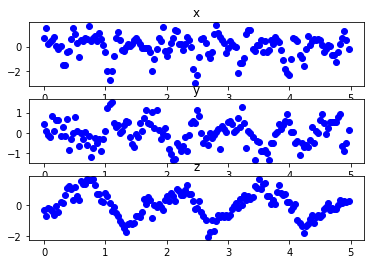

In [9]:
resample_rate = 30
sample_period = 5 #seconds
records = getRecordsFromTxt("HMP_Dataset/Walk/")
records = applyFil(records, 1, resample_rate)
data = randSegFromRecords(records, resample_rate * sample_period)
#print(data[:,0])
sampleMeanShiftPlot(data, resample_rate)
print("data x y z max", np.max(data[:,0]), np.max(data[:,1]), np.max(data[:,2]))
print("data x y z min", np.min(data[:,0]), np.min(data[:,1]), np.min(data[:,2]))
#TODO plot x y z separately

In [11]:
def samplePlot(data, sample_rate):
    
    t = np.arange(0, data.shape[0] / sample_rate, 1 / sample_rate)

    data = np.swapaxes(data, 0, 1)
    [bx, by, bz] = data

    fig = plt.figure()
    plt.subplot(311)
    plt.plot(t, bx, 'bo')
    plt.title('x')

    plt.subplot(312)
    plt.plot(t, by, 'bo')
    plt.title('y')
    
    plt.subplot(313)
    plt.plot(t, bz, 'bo')
    plt.title('z')

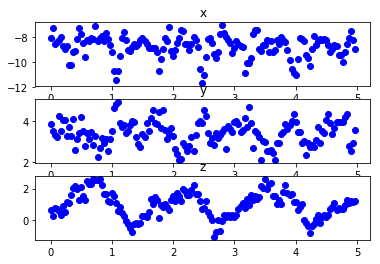

In [12]:
samplePlot(data, resample_rate)

In [14]:
## Generating resting data
## x^2 + b^2 + c^2 = 1
## x, y, z all scaled by alpha s.t.
## (alpha*x)^2 + (alpha*x)^2 + (alpha*x)^2 = 1
## alpha = (x^2 + b^2 + c^2)^0.5

rand_vect = np.random.rand(3)
rand_vect_tmp = np.square(rand_vect)
rand_vect_tmp = np.sum(rand_vect_tmp)
alpha = np.power(rand_vect_tmp, -0.5)
rand_vect = rand_vect * alpha
#np.sum(np.power(rand_vect, 2))
fake_acc_data = 
print '{0:2d} {1:3d} {2:4d}'.format(rand_vect[0], rand_vect[1], rand_vect[2])
rand_vect

array([0.82131558, 0.4725537 , 0.31958365])